In [4]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import pandas as pd                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
import numpy as np

df=pd.read_csv('diabetes.csv')
df.shape


# split into input (X) and output (Y) variables
X=df.drop('Outcome',axis=1)
Y=df['Outcome']
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=5)
# further split data into multiple dataset, thus, with same samples (rows) but different dimensions (columns)
X1_train, X2_train=x_train[['Pregnancies','Glucose','BloodPressure','SkinThickness']], x_train[['Insulin','BMI','DiabetesPedigreeFunction','Age']]
X1_test,X2_test=x_test[['Pregnancies','Glucose','BloodPressure','SkinThickness']], x_test[['Insulin','BMI','DiabetesPedigreeFunction','Age']]

X_train_list = [X1_train, X2_train]
X_test_list = [X1_test, X2_test]

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=4, kernel_initializer= 'uniform' , activation= 'relu' ))
    model.add(Dense(8, kernel_initializer= 'uniform' , activation= 'relu' ))
    model.add(Dense(1, kernel_initializer= 'uniform' , activation= 'sigmoid' ))
    # Compile model
    model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
    return model


# creating two model instances, which will be traind on 2 different datasets
DNN1=KerasClassifier(build_fn=create_model,epochs=20, batch_size=10, verbose=0)
DNN_pipe1=Pipeline([('standardizer', StandardScaler()), ('cnn', DNN1)])
DNN2=KerasClassifier(build_fn=create_model,epochs=15, batch_size=20, verbose=0)
DNN_pipe2=Pipeline([('standardizer', StandardScaler()), ('cnn', DNN2)])

classifiers=[DNN_pipe1,DNN_pipe2]


# Training multiple classifiers using fit()
def multiple_classifier_fit(clsf_list,x_train_list,y):
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    classifiers=[ clsf.fit(X,y) for clsf,X in zip(clsf_list,x_train_list)]
    return classifiers

# Weighted average ensemble on different datasets
def ensemble_predict(estimator_list, X_test_list, weights):
    pred1 = np.asarray([clsf.predict_proba(X) for clsf, X in zip(estimator_list, X_test_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)    # weighting and averaging 
    pred = np.argmax(pred2, axis=1)                       # index of highest predicted weighted value
    return pred,pred2  # pred_y is either 0 or 1 and pred_y_probs in range (0,1).Whiles pred_y is needed for calculating predictions, pred_y_probs will be used for ROC and AUC calculation     
def Gridsearch():
    # Weights
    w=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracies,W_list,i,j=[],[],0,8
    while (i<len(w)):
        W=[w[i],w[j]]
        # For every weight pair combination, compute the accuracy of the ensemble model
        fitted_classifiers=multiple_classifier_fit(classifiers,X_train_list,y_train)
        pred_y,pred_y_probs= ensemble_predict(fitted_classifiers,X_test_list,W)
        accuracy=accuracy_score(y_test, pred_y)
        # add weight pair and accuracy to the dictionary
        accuracies.append(accuracy)
        W_list.append(W)
        i+=1
        j-=1
    return accuracies, W_list

print('Ensemble model weight pair with corresponding accuracies:\n')
scores,weight=Gridsearch()
for wgt,sc in zip(weight,scores):
    print(wgt,'->',sc)


Ensemble model weight pair with corresponding accuracies:

[0.1, 0.9] -> 0.7402597402597403
[0.2, 0.8] -> 0.7532467532467533
[0.3, 0.7] -> 0.7727272727272727
[0.4, 0.6] -> 0.7922077922077922
[0.5, 0.5] -> 0.7467532467532467
[0.6, 0.4] -> 0.7792207792207793
[0.7, 0.3] -> 0.7792207792207793
[0.8, 0.2] -> 0.7662337662337663
[0.9, 0.1] -> 0.7857142857142857


#### From the above results, best pair of weight for the ensemble DNN classier was [0.6, 0.4] reaching 79.22% accuracy

###  ROC curve and AUC of the best weight pair

AUC score: 0.871

 ROC curve


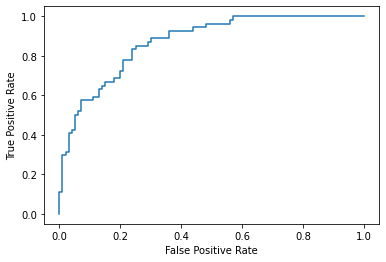

In [6]:
W=[0.4,0.6]
fitted_classifiers=multiple_classifier_fit(classifiers,X_train_list,y_train)
pred_y,pred_y_probs= ensemble_predict(fitted_classifiers,X_test_list,W)# pred_y is either 0 or 1 and pred_y_probs in range (0,1)
pred_y_probs=pred_y_probs[:,1]
# Compute AUC score
auc=roc_auc_score(y_test, pred_y_probs)
print('AUC score: %.3f' %(auc))
# ROC  curve
fpr, tpr, treshold = roc_curve(y_test, pred_y_probs)
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
print('\n ROC curve')
pyplot.show()